# Plot Map

## Cluster Setting
Dask is a flexible library for parallel computing in Python. 

Dask.distributed is a lightweight library for distributed computing in Python.

The Client is the primary entry point for users of dask.distributed.

In [1]:
## Distributed computing
from dask.distributed import Client, progress
from dask_kubernetes import KubeCluster

cluster = KubeCluster() # reads provided yaml file
# cluster.scale_up(10)  # specify number of nodes explicitly
# cluster.adapt(minimum=1, maximum=100)  # or dynamically scale based on current workload
cluster.adapt(minimum = 2, maximum = 8)
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:    tcp://10.32.2.13:39439
distributed.scheduler - INFO -   dashboard at:                     :8787


In [2]:
# Connect to distributed cluster and override default
client = Client(cluster) 
client

distributed.scheduler - INFO - Receive client connection: Client-6695ee98-4610-11ea-85ea-da2c4b104ce6
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.2.13:39439 Dashboard: /user/0000-0001-5234-177x/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Environment Setting

The pangeo platform is using an old version xesmf. In order to avoid error, we need to update the xesmf by execute the following code:

(it seems we need to do it every time)

In [ ]:
!pip install --upgrade git+https://github.com/JiaweiZhuang/xESMF.git

distributed.scheduler - INFO - Register tcp://10.32.4.3:43291
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.4.3:43291
distributed.core - INFO - Starting established connection


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # Pythonic file-system for Google Cloud Storage
import xesmf as xe

%matplotlib inline

In [5]:
def get_data(df, var, model, expe, freq):
    try:
        uri = df[(df.variable_id == var) & \
                 (df.source_id == model) & \
                 (df.experiment_id == expe) & \
                 (df.table_id == freq)].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    except:
        ds = []
        print(model, ": no data")
    return ds        

Fetch the data from 15 models that have biogeochem output.



In [9]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
models = ['CanESM5', 'CESM2', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GFDL-CM4',
          'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'IPSL-CM6A-LR', 'MIROC-ES2L',
          'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM', 'UKESM1-0-LL']

var = 'tos'
expe = 'historical'
freq = 'Omon'

start_time = '1991'
end_time = '2010'

xrays = []
for model in models:
    xray = get_data(df, var, model, expe, freq)
    xrays.append(xray)
xray_dic = {key:value for key, value in zip(models, xrays)}

MPI-ESM1-2-HR : no data
NorCPM1 : no data
NorESM2-LM : no data


### save file
no need to save file here, just for test.

In [ ]:
# no need to run this box

aves = []

for model in tqdm(models):
    try:
        ds = xray_dic[model].sel(time=slice('1990','2009')).mean(dim='time').tos
        
        if 'latitude' in ds.coords:
            ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
        if 'nav_lat' in ds.coords:
            ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
            
        ds = ds.load()
        outname = 'mean/' + str(model) + '.nc'
        ds.to_netcdf(outname)
            
    except Exception as E:
        ds = []
        print(model, E)

    aves.append(ds)

ave_dic = {key:value for key, value in zip(models, aves)}

## Regridding

Behzad's code for regridding:

nearest from scipy.interpolate.datagrid
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

Here we use xesmf
https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html


In [7]:
# Create a Global 2D rectilinear grid of 1 degree x 1 degree
ds_out = xe.util.grid_global(1, 1)
ds_out

<xarray.Dataset>
Dimensions:  (x: 360, x_b: 361, y: 180, y_b: 181)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) int64 -180 -179 -178 -177 -176 ... 176 177 178 179 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [7]:
# Another method for out grid:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0)),
                    }
                   )
ds_out

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    *empty*

In [ ]:
#use the file that have been saved from above save file process
# no need to run this box

regrids = []
for model in tqdm(models):
    try:
        dsf = 'mean/' + str(model) + '.nc'
        ds = xr.open_dataset(dsf)
        
        dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
        dsr_out = dsr(ds)
        dsr.clean_weight_file()
        
        #outname = 'Regrid/' + str(model) + '_reg.nc'
        #dsr_out.to_netcdf(outname)
        
    except Exception as E:
        dsr_out = []
        print(model, E)
    regrids.append(dsr_out)
regrid_dic = {key:value for key, value in zip(models, regrids)}

    regredding

In [11]:
%%time

regrids = []
for model in models:
    if isinstance(xray_dic[model], xr.Dataset):
        ds = xray_dic[model].sel(time=slice(start_time, end_time))[var]
        
        if 'latitude' in ds.coords:
            ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
        if 'nav_lat' in ds.coords:
            ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
            
                
        dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
        dsr._grid_in = None
        dsr._grid_out = None
        dsr_out = dsr(ds)
        dsr.clean_weight_file()
        
    else:
        dsr_out = []
        
    regrids.append(dsr_out)
    
regrid_dic = {key:value for key, value in zip(models, regrids)}

Create weight file: bilinear_291x360_181x361_peri.nc
Remove file bilinear_291x360_181x361_peri.nc
Create weight file: bilinear_384x320_181x361_peri.nc
Remove file bilinear_384x320_181x361_peri.nc
Create weight file: bilinear_180x360_181x361_peri.nc
Remove file bilinear_180x360_181x361_peri.nc
Create weight file: bilinear_294x362_181x361_peri.nc
Remove file bilinear_294x362_181x361_peri.nc
Create weight file: bilinear_1080x1440_181x361_peri.nc
Remove file bilinear_1080x1440_181x361_peri.nc
Create weight file: bilinear_576x720_181x361_peri.nc
Remove file bilinear_576x720_181x361_peri.nc
Create weight file: bilinear_90x144_181x361_peri.nc
Remove file bilinear_90x144_181x361_peri.nc
Create weight file: bilinear_90x144_181x361_peri.nc
Remove file bilinear_90x144_181x361_peri.nc
Create weight file: bilinear_332x362_181x361_peri.nc
Remove file bilinear_332x362_181x361_peri.nc
Create weight file: bilinear_256x360_181x361_peri.nc
Remove file bilinear_256x360_181x361_peri.nc
Create weight file: 

distributed.scheduler - INFO - Retire worker names (0,)
distributed.deploy.adaptive - INFO - Retiring workers [0]
distributed.scheduler - INFO - Remove worker tcp://10.32.4.3:43291
distributed.core - INFO - Removing comms to tcp://10.32.4.3:43291
distributed.scheduler - INFO - Lost all workers
distributed.scheduler - INFO - Retire worker names (1,)
distributed.deploy.adaptive - INFO - Retiring workers [1]
distributed.scheduler - INFO - Retire worker names (2, 3)
distributed.deploy.adaptive - INFO - Retiring workers [2, 3]
distributed.scheduler - INFO - Register tcp://10.32.4.4:37409
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.4.4:37409
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Retire worker names (4,)
distributed.deploy.adaptive - INFO - Retiring workers [4]
distributed.scheduler - INFO - Retire worker names (5,)
distributed.deploy.adaptive - INFO - Retiring workers [5]
distributed.scheduler - INFO - Retire w

CPU times: user 20.8 s, sys: 4.52 s, total: 25.3 s
Wall time: 5min 27s


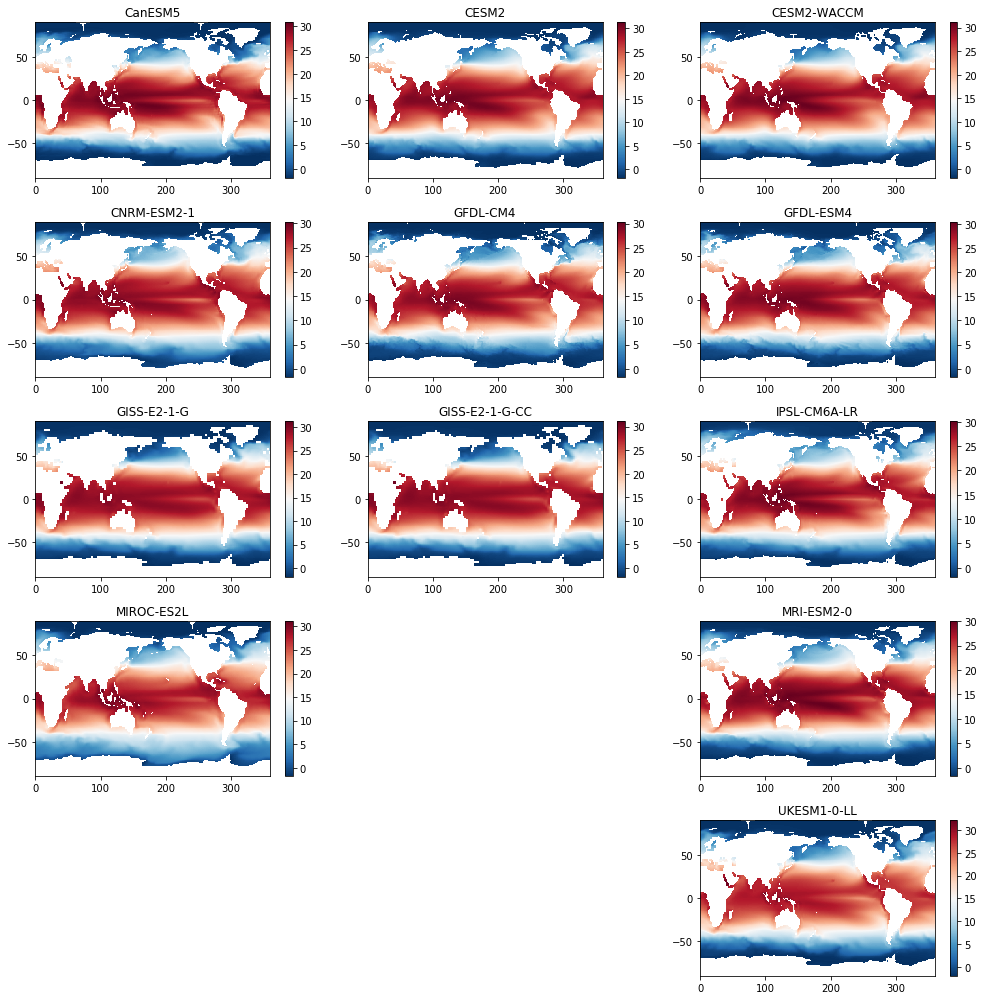

distributed.scheduler - INFO - Remove worker tcp://10.32.6.2:39451
distributed.core - INFO - Removing comms to tcp://10.32.6.2:39451
distributed.scheduler - INFO - Lost all workers


In [12]:
# plotting

plt.figure(figsize=(14,14))
i = 0
for model in models:  
    i = i + 1
    if isinstance(xray_dic[model], list):
        continue
    else:
        s = regrid_dic[model].mean(dim='time')
    ax = plt.subplot(5,3,i)
    plt.pcolormesh(regrid_dic[model].lon, regrid_dic[model].lat, s, cmap=plt.cm.RdBu_r)
    plt.colorbar()
    ax.title.set_text(str(model))
plt.tight_layout()
plt.savefig('tos.png', dpi=600)

In [14]:
client.close()
cluster.close()